# ✅   Effect of expiration conditions on instore sales 


Neste notebook vamos fazer uma análise de clusters por loja identificando as condições de etiquetagem dos produtos e os seus impactos nas vendas.

## Importar bibliotecas

In [2]:
# Importing necessary libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # Library for statistical graphics
from sklearn.cluster import KMeans  # K-Means clustering algorithm
from sklearn.preprocessing import StandardScaler  # For data normalization
from sklearn.decomposition import PCA  # For dimensionality reduction
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualizations
from sklearn.metrics import silhouette_score  # Imports the Silhouette Score metric, which evaluates the quality of the formed clusters


## Importar o Dataset

In [3]:
# Load the Excel data file into a dataframe
df = pd.read_excel('merged_data.xlsx')

# Display the first rows of the dataframe
df.head()

,idstore,district,selling_square_ft,type,sku,brand,oldpvp,new_pvp,discount,discount%interval,...,profit (€),perc_expiring_sku,perc_interval,expiring_date,labelling_date,sell_date,expiring_days,period_sell_vs_labelling,period_expiring_vs_labelling,sold
0,1,Évora,4762,Large,1,marca1,4.22,2.11,0.5,[40 - 60%[,...,0.3376,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
1,1,Évora,4762,Large,1,marca1,3.96,1.98,0.5,[40 - 60%[,...,0.3168,0.005025,[0 - 10%[,2021-10-02,2021-10-01,NaT,199,NaN,1,False
2,1,Évora,4762,Large,1,marca1,4.74,2.37,0.5,[40 - 60%[,...,0.3792,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True
3,1,Évora,4762,Large,1,marca1,4.20,2.10,0.5,[40 - 60%[,...,0.3360,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-02,199,1.0,2,True
4,1,Évora,4762,Large,1,marca1,4.62,2.31,0.5,[40 - 60%[,...,0.3696,0.010050,[0 - 10%[,2021-10-03,2021-10-01,2021-10-03,199,2.0,2,True


## Calculo de métricas 

### Média de desconto por loja

In [4]:
# Calculate the average discount per store
mean_discount_per_store = df.groupby('idstore')['discount'].mean().reset_index()

# Rename the column to indicate it is the average discount
mean_discount_per_store.rename(columns={'discount': 'mean_discount'}, inplace=True)

# Display the result
print(mean_discount_per_store)

     idstore  mean_discount
0          1       0.342578
1          2       0.324714
2          3       0.301029
3          4       0.305130
4          5       0.301619
..       ...            ...
326      328       0.500000
327      329       0.300000
328      330       0.300000
329      331       0.300000
330      332       0.500000

[331 rows x 2 columns]


### Média de percentagem de expiração de produtos por loja

In [5]:
# Calculate the average perc_expiring_sku per store
mean_perc_expiring_sku_per_store = df.groupby('idstore')['perc_expiring_sku'].mean().reset_index()

# Rename the column to indicate it is the average perc_expiring_sku
mean_perc_expiring_sku_per_store.rename(columns={'perc_expiring_sku': 'mean_perc_expiring_sku'}, inplace=True)

# Display the result
print(mean_perc_expiring_sku_per_store)

     idstore  mean_perc_expiring_sku
0          1                0.446587
1          2                0.374760
2          3                0.346032
3          4                0.196993
4          5                0.363834
..       ...                     ...
326      328                0.053030
327      329                0.333333
328      330                0.200000
329      331                0.333333
330      332                0.028926

[331 rows x 2 columns]


### Soma de vendas por loja

In [6]:
# Calculate the sum of sold items per store
sum_sold_per_store = df.groupby('idstore')['sold'].sum().reset_index()

# Rename the column to indicate it is the sum of sold items
sum_sold_per_store.rename(columns={'sold': 'sum_sold'}, inplace=True)

# Display the result
print(sum_sold_per_store)

     idstore  sum_sold
0          1       345
1          2       448
2          3       160
3          4       191
4          5       699
..       ...       ...
326      328         0
327      329         3
328      330         0
329      331         2
330      332         0

[331 rows x 2 columns]


## Gerar um novo dataframe com as métricas calculadas

In [7]:
# Merge the calculated metrics into a new dataframe
merged_metrics = mean_perc_expiring_sku_per_store.merge(mean_discount_per_store, on='idstore')
merged_metrics = merged_metrics.merge(sum_sold_per_store, on='idstore')

# Display the new dataframe
print(merged_metrics)

     idstore  mean_perc_expiring_sku  mean_discount  sum_sold
0          1                0.446587       0.342578       345
1          2                0.374760       0.324714       448
2          3                0.346032       0.301029       160
3          4                0.196993       0.305130       191
4          5                0.363834       0.301619       699
..       ...                     ...            ...       ...
326      328                0.053030       0.500000         0
327      329                0.333333       0.300000         3
328      330                0.200000       0.300000         0
329      331                0.333333       0.300000         2
330      332                0.028926       0.500000         0

[331 rows x 4 columns]


In [8]:
# Check if the dataset has null values
null_values = merged_metrics.isnull().sum()
print(null_values)

idstore                   0
mean_perc_expiring_sku    0
mean_discount             0
sum_sold                  0
dtype: int64


## Modelo K-means clustering

### Normalização dos dados e método do cotovelo para encontrar o número ideal de clusters

In [9]:
# Remove the idstore column
X = merged_metrics.drop(columns=['idstore'])
X

,mean_perc_expiring_sku,mean_discount,sum_sold
0,0.446587,0.342578,345
1,0.374760,0.324714,448
2,0.346032,0.301029,160
3,0.196993,0.305130,191
4,0.363834,0.301619,699
...,...,...,...
326,0.053030,0.500000,0
327,0.333333,0.300000,3
328,0.200000,0.300000,0
329,0.333333,0.300000,2


In [10]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\joaov\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\joaov\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


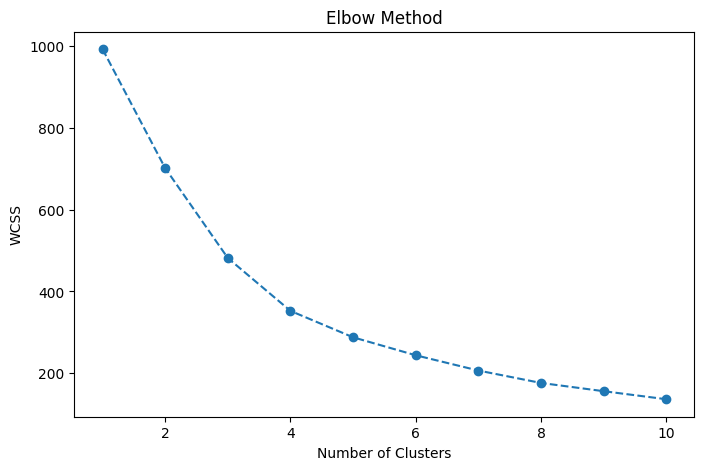

In [11]:
# Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()


### Resultados do modelo com 4 clusters

In [12]:
# Define the number of clusters
n_clusters = 4

# Create the KMeans model
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Fit the model to the scaled data
kmeans_model.fit(X_scaled)

# Display the cluster centroids
print("Cluster centroids:")
print(kmeans_model.cluster_centers_)

Cluster centroids:
[[ 0.36995835 -0.09879751 -0.14231449]
 [ 0.38783298  0.06332542  1.87393616]
 [-1.65727509 -0.43427175 -0.68968516]
 [-2.611871    5.2128491  -1.23469161]]


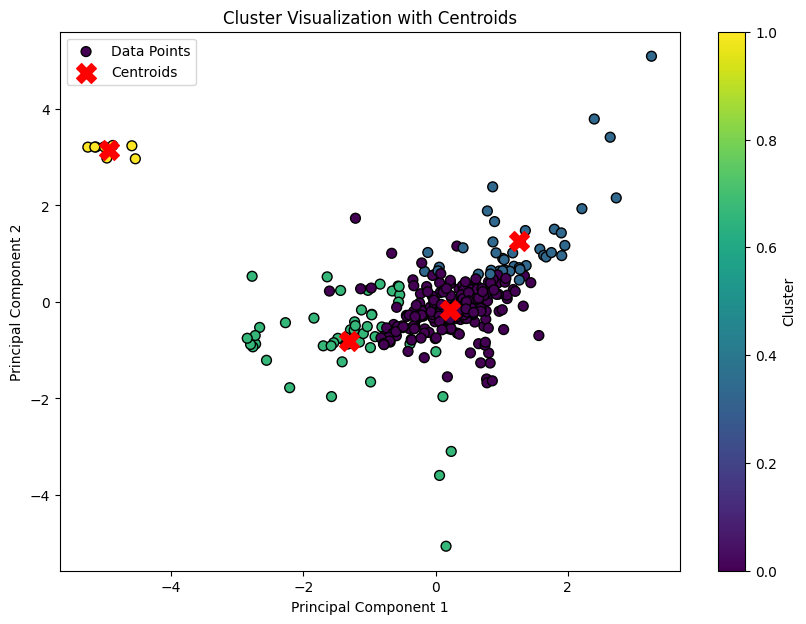

In [13]:
# Apply PCA to reduce the dimensionality to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data to the new reduced space

# Get the cluster labels assigned by the K-Means model
labels = kmeans_model.labels_

# Create the figure to visualize the clusters
plt.figure(figsize=(10, 7))

# Plot the data points in the 2D space reduced by PCA, colored by cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, marker='o', edgecolor='k', s=50, label='Data Points')

# Get the coordinates of the centroids in the original space
centroids = kmeans_model.cluster_centers_

# Transform the centroids to the new reduced space by PCA
centroids_pca = pca.transform(centroids)

# Plot the centroids on the graph, representing them with a different marker (X) and red color
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroids')

# Add title and axis labels to the plot
plt.title('Cluster Visualization with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend for better interpretation
plt.legend()

# Add a color bar to indicate the clusters
plt.colorbar(label='Cluster')

# Show the plot
plt.show()

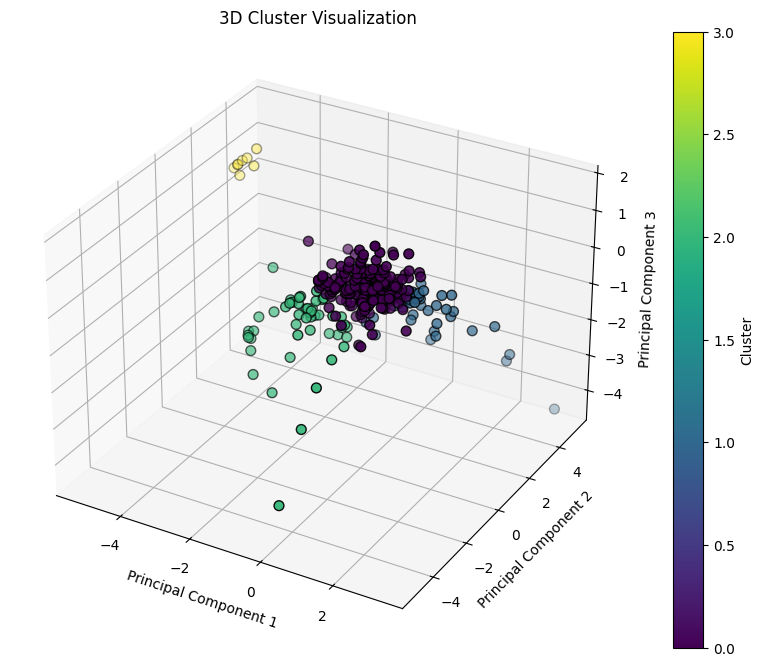

In [14]:
# Reduce the dimensionality of the data to 3 principal components using PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)  # Transform the scaled data to the new 3D reduced space

# Create a figure for 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot the data points in the three-dimensional space, coloring them according to the clusters
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                     c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Add title and axis labels
ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a color bar to indicate the clusters
fig.colorbar(scatter, ax=ax, label='Cluster')

# Display the plot
plt.show()

In [15]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.43043886365583295


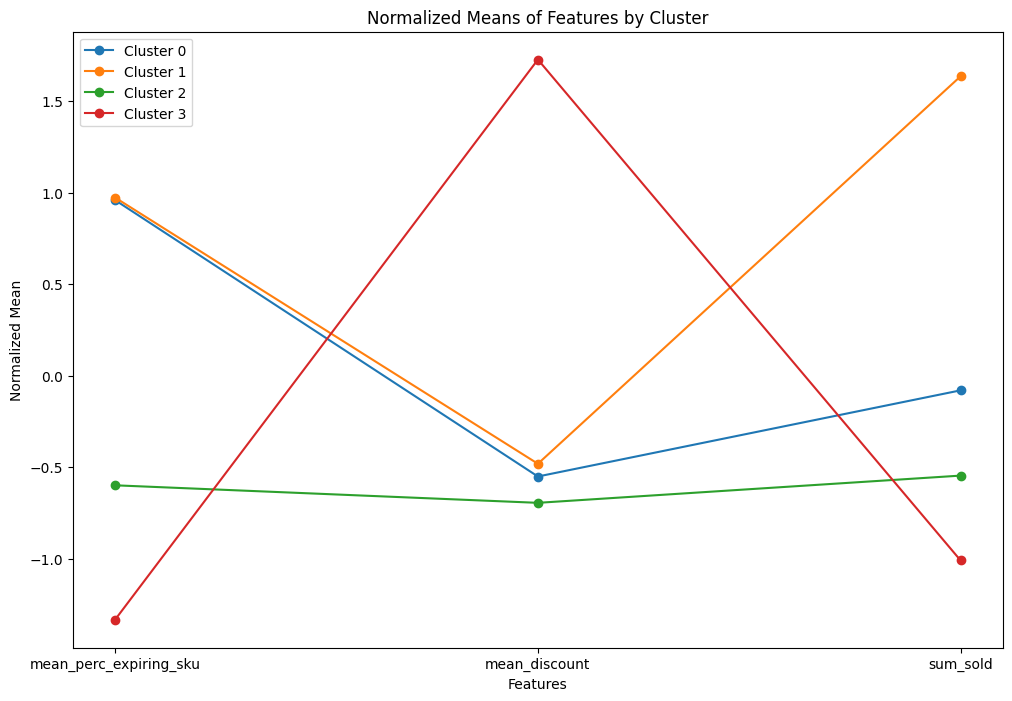

In [16]:
# Define the features to be analyzed and plotted
features_to_plot = ['mean_perc_expiring_sku', 'mean_discount', 'sum_sold']  

# Calculate the mean of the features for each cluster
cluster_means = merged_metrics.copy()  # Create a copy of the original DataFrame
cluster_means['Cluster'] = labels  # Add the cluster labels to the DataFrame
cluster_means = cluster_means.groupby('Cluster').mean().reset_index()  # Group by cluster and calculate the mean of the variables

# Normalize the data to allow fair comparisons between the variables
scaler = StandardScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means[features_to_plot]), 
                                        columns=features_to_plot)  # Normalize only the selected columns

# Add the cluster column to the normalized DataFrame to maintain the association
cluster_means_normalized['Cluster'] = cluster_means['Cluster'].values

# Create the figure for the line plot
plt.figure(figsize=(12, 8))

# Iterate over each cluster and plot the corresponding line
for cluster in cluster_means_normalized['Cluster']:
    plt.plot(features_to_plot, 
             cluster_means_normalized[cluster_means_normalized['Cluster'] == cluster].iloc[0][features_to_plot], 
             marker='o', label=f'Cluster {cluster}')  # Add markers and labels for each cluster

# Add title and axis labels
plt.title('Normalized Means of Features by Cluster')
plt.xlabel('Features')
plt.ylabel('Normalized Mean')

# Add a legend for better interpretation
plt.legend()

# Remove the background grid for a cleaner look
plt.grid(False)

# Display the plot
plt.show()

In [17]:
# Count the number of stores per cluster
stores_per_cluster = pd.Series(labels).value_counts().sort_index()

# Display the result
print(stores_per_cluster)

0    233
1     41
2     49
3      8
Name: count, dtype: int64


### Resultado do modelo com 3 clusters

In [18]:
# Define the number of clusters
n_clusters = 3

# Create the KMeans model
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Fit the model to the scaled data
kmeans_model.fit(X_scaled)

# Display the cluster centroids
print("Cluster centroids:")
print(kmeans_model.cluster_centers_)

Cluster centroids:
[[ 0.47272265 -0.07317776  0.29461037]
 [-2.611871    5.2128491  -1.23469161]
 [-1.09625888 -0.28825365 -0.72064697]]


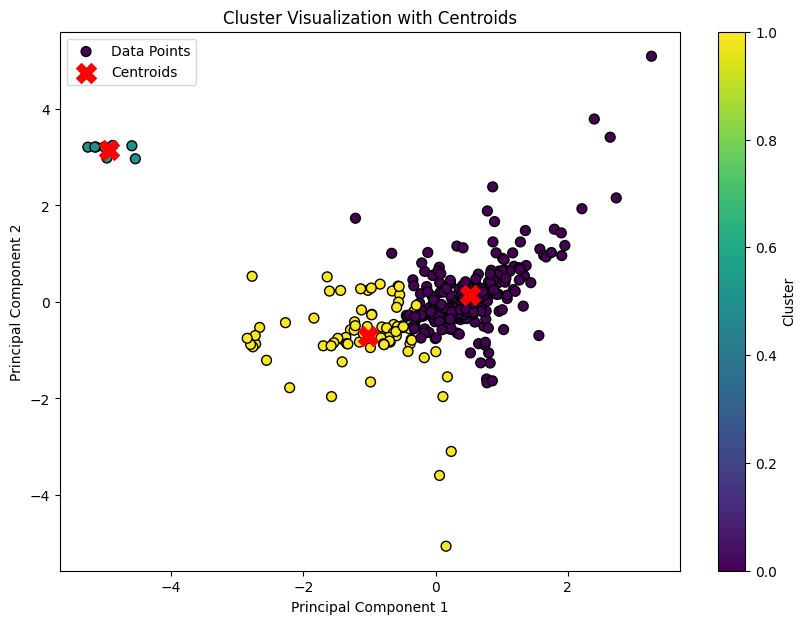

In [19]:
# Apply PCA to reduce the dimensionality to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data to the new reduced space

# Get the cluster labels assigned by the K-Means model
labels = kmeans_model.labels_

# Create the figure to visualize the clusters
plt.figure(figsize=(10, 7))

# Plot the data points in the 2D space reduced by PCA, colored by cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, marker='o', edgecolor='k', s=50, label='Data Points')

# Get the coordinates of the centroids in the original space
centroids = kmeans_model.cluster_centers_

# Transform the centroids to the new reduced space by PCA
centroids_pca = pca.transform(centroids)

# Plot the centroids on the graph, representing them with a different marker (X) and red color
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroids')

# Add title and axis labels to the plot
plt.title('Cluster Visualization with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend for better interpretation
plt.legend()

# Add a color bar to indicate the clusters
plt.colorbar(label='Cluster')

# Show the plot
plt.show()

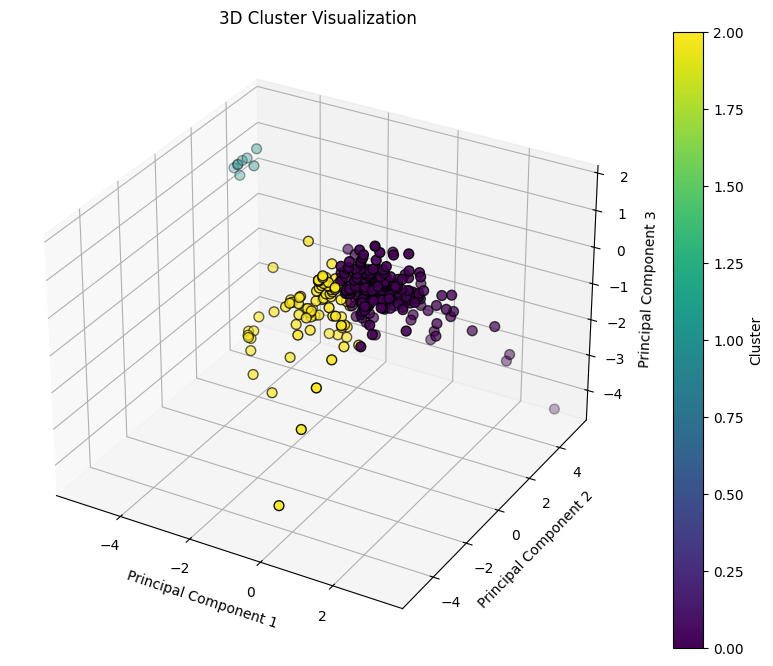

In [20]:
# Reduce the dimensionality of the data to 3 principal components using PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)  # Transform the scaled data to the new 3D reduced space

# Create a figure for 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot the data points in the three-dimensional space, coloring them according to the clusters
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                     c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Add title and axis labels
ax.set_title('3D Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a color bar to indicate the clusters
fig.colorbar(scatter, ax=ax, label='Cluster')

# Display the plot
plt.show()

In [21]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4046345507675192


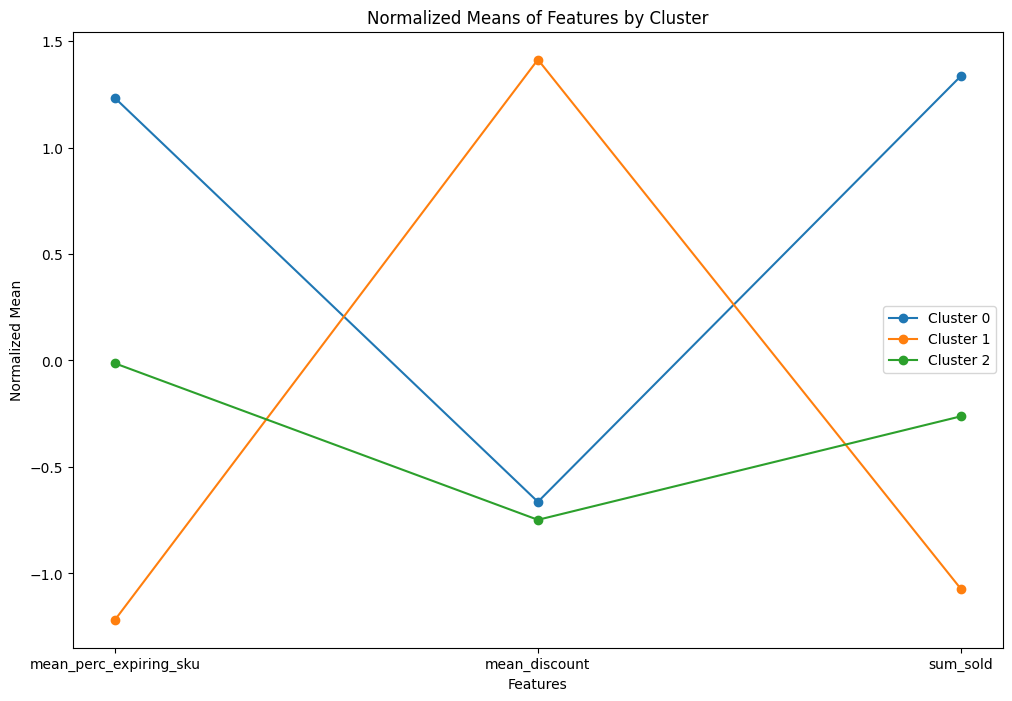

In [22]:
# Define the features to be analyzed and plotted
features_to_plot = ['mean_perc_expiring_sku', 'mean_discount', 'sum_sold']  

# Calculate the mean of the features for each cluster
cluster_means = merged_metrics.copy()  # Create a copy of the original DataFrame
cluster_means['Cluster'] = labels  # Add the cluster labels to the DataFrame
cluster_means = cluster_means.groupby('Cluster').mean().reset_index()  # Group by cluster and calculate the mean of the variables

# Normalize the data to allow fair comparisons between the variables
scaler = StandardScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means[features_to_plot]), 
                                        columns=features_to_plot)  # Normalize only the selected columns

# Add the cluster column to the normalized DataFrame to maintain the association
cluster_means_normalized['Cluster'] = cluster_means['Cluster'].values

# Create the figure for the line plot
plt.figure(figsize=(12, 8))

# Iterate over each cluster and plot the corresponding line
for cluster in cluster_means_normalized['Cluster']:
    plt.plot(features_to_plot, 
             cluster_means_normalized[cluster_means_normalized['Cluster'] == cluster].iloc[0][features_to_plot], 
             marker='o', label=f'Cluster {cluster}')  # Add markers and labels for each cluster

# Add title and axis labels
plt.title('Normalized Means of Features by Cluster')
plt.xlabel('Features')
plt.ylabel('Normalized Mean')

# Add a legend for better interpretation
plt.legend()

# Remove the background grid for a cleaner look
plt.grid(False)

# Display the plot
plt.show()

In [23]:
# Count the number of stores per cluster
stores_per_cluster = pd.Series(labels).value_counts().sort_index()

# Display the result
print(stores_per_cluster)

0    239
1      8
2     84
Name: count, dtype: int64
